In [7]:
%matplotlib inline
import numpy as np
import pylab as pl
import scipy.special as special
from scipy.optimize import curve_fit
#import mpmath as mm
from scipy.integrate import quad
from scipy.integrate import nquad

# Set plot parameters to make beautiful plots
pl.rcParams['figure.figsize']  = 12, 7.5
pl.rcParams['lines.linewidth'] = 1.5
pl.rcParams['font.family']     = 'serif'
pl.rcParams['font.weight']     = 'bold'
pl.rcParams['font.size']       = 20  
pl.rcParams['font.sans-serif'] = 'serif'
#pl.rcParams['text.usetex']     = True
pl.rcParams['axes.linewidth']  = 1.5
pl.rcParams['axes.titlesize']  = 'medium'
pl.rcParams['axes.labelsize']  = 'medium'

pl.rcParams['xtick.major.size'] = 8     
pl.rcParams['xtick.minor.size'] = 4     
pl.rcParams['xtick.major.pad']  = 8     
pl.rcParams['xtick.minor.pad']  = 8     
pl.rcParams['xtick.color']      = 'k'     
pl.rcParams['xtick.labelsize']  = 'medium'
pl.rcParams['xtick.direction']  = 'in'    

pl.rcParams['ytick.major.size'] = 8     
pl.rcParams['ytick.minor.size'] = 4     
pl.rcParams['ytick.major.pad']  = 8     
pl.rcParams['ytick.minor.pad']  = 8     
pl.rcParams['ytick.color']      = 'k'     
pl.rcParams['ytick.labelsize']  = 'medium'
pl.rcParams['ytick.direction']  = 'in'    






#want to plot the integrand in Eq. 60 of the paper
#with filled in values of I(...), delta(yn), 

#constants in natural units
#m = 1.
#c = 1.
theta_e = 10.
#w without specific declear should of value 10
w = 10.
#theta_e_1 = 10.
#nu_c = 1
#B = 10.
#e = 1


#constants in Gaussian cgs units (values from harmony)
m = 9.1093826e-28
c = 2.99792458e10
e = 4.80320680e-10
B = 30.0
n_e = 1.
h = 6.6260755e-27
k = 1.380658e-16
T_e = m * c**2 * theta_e / k


#variables to be set (frequency, observer angle, width of delta function, electron number density, 
# sum index n)

kappa = 3.5
theta = np.pi/3.
epsilon = 0.01
n_e = 1.
nu_c = e * B / (2. * np.pi * m * c)
nu = 100 * nu_c
nu_s = (2./9.) * nu_c * theta_e**2 * np.sin(theta)
nu_k = nu_c * w**2. * np.sin(theta)
nu_w = nu_c * (w * kappa)**2 * np.sin(theta)
n_e_nt = 1.
#p_PL = 2.2
p_PL = 2.5
gamma_50_min = 1.
gamma_50_max = 1000.
#gamma_50_max = 100.
C = 1.
n_dn = (nu / nu_c) * abs(np.sin(theta))
Index_cutoff = 0.001

gamma_cutoff = 1000.
#print nu_c

In [8]:
def emi_fitting_low_prof(x):
    X = x / nu_k
    prefactor = X**(1./3.) * nu_k * n_e * e**2 * (1./c) * (1./w**2)
    body = special.gamma(kappa - 4./3.) / special.gamma(kappa - 2.)
    tail = 4. * np.pi / (3.**(7./3.) * kappa**(2./3.))
    f = prefactor * body * tail
    return f


def emi_fitting_mid_prof(x):
    prefactor = n_e * e**2. * nu_c * np.sin(theta) / c
    body = (x / nu_k)**( - (kappa - 2.)/2.)
    tail_1 = 2**(-(kappa + 3.)/2.) * 3**((kappa - 1.)/2.) * np.pi**(1./2.)
    tail_2 = special.gamma((kappa + 1.)/2.) * (kappa - 2.) * kappa**(kappa - 1.)
    f = prefactor * body * tail_1 * tail_2
    return f

def emi_fitting_mid_ours(x):
    
    term1 = 1./(c**2 * kappa * m * w**2)
    term2 = B * e**3 * 2.**(- kappa - 5./2.)
    term3 = (kappa**2 - 3. * kappa + 2.) * (np.pi/3.)**((1./2.) - (kappa / 2.))
    term4 = n_e * np.sin(theta) * (kappa * w)**(kappa)
    term5 = np.sqrt((c * m * x)/( B * e * np.sin(theta)))
    term6 = (B * e * np.sin(theta)/(c * m * x))**((kappa - 1.)/2.)
    term7 = special.gamma((kappa - 1.)/2.)  
    term8 = special.gammainc((kappa - 1.)/2., (4. * c * m * x * np.pi)/(3. * B * e * np.sin(theta)))
    
    f = term1 * term2 * term3 * term4 * term5 * term6 * (term7 - term8)
    return f


def emi_fitting_mis_ours_2(x):
    
    term1 = 1./c
    term2 = e**2 * 2.**(- kappa - 5./2.)
    term3 = (kappa - 2.) * (kappa - 1.) * kappa
    term4 = (np.pi/3.)**((1. - kappa)/2.)
    term5 = n_e * x * (kappa * w)**(kappa - 2.)
    term6 = np.sqrt((c * m * x )/( B * e * np.sin(theta)))
    term7 = (B * e * np.sin(theta) / (c * m * x))**((kappa + 1.)/2.)
    term8 = special.gamma((kappa - 1.)/2.) 
    term9 = special.gammainc((kappa - 1.)/2., (4. * c * m * x * np.pi)/(3. * B * e * np.sin(theta)))

    f = term1 * term2 * term3 * term4 * term5 * term6 * term7 * (term8 - term9)
    return f

def fit(nuratio):
    nu = nuratio * nu_c
    term1 = e**2. * 2.**(-kappa-5./2.) * (kappa-2.) * (kappa-1.) * kappa
    term2 = (np.pi/3.)**(1./2.-kappa/2.) * n_e * nu * (kappa*w)**(kappa-2.)
    term3 = np.sqrt((c*m*nu)/(np.sin(theta)*B*e))
    term4 = ((B*e*np.sin(theta))/(c*m*nu))**((kappa+1.)/2.)
    term5 = (special.gamma((kappa-1.)/2. - special.gammainc((kappa-1.)/2., (4.*c*m*nu*np.pi)/(np.sin(theta)*3.*B*e))))
    ans = (term1*term2*term3*term4*term5)/c 
    return ans


def kappa_low(nuratio):
    nu = nuratio * nu_c
    X = nu/nu_w
    norm = 4. * np.pi * special.gamma(kappa-4./3.) / (3.**(7./3.) * special.gamma(kappa-2.))
    dimensional = (n_e * e**2.)/(c * kappa**2. * w**2.)
    ans = norm * dimensional * nu_w * X**(1./3.)
    return ans

def kappa_high(nuratio):
    nu = nuratio * nu_c
    X = nu/nu_w
    term1 = (1./4.) * 3.**((kappa-1.)/2.) * (kappa-2.) * (kappa-1.)
    term2 = special.gamma(kappa/4. - 1./3.) * special.gamma(kappa/4. + 4./3.) 
    term3 = (n_e * e**2. * nu_c * np.sin(theta)) / c
    ans = term1*term2*term3 * X**(-(kappa-2.)/2.)
    return ans




def kappa_low_anu(nuratio):
    
    nu = nuratio * nu_c
    X = nu/nu_w
    norm = 4. * np.pi * special.gamma(kappa-4./3.) / (3.**(7./3.) * special.gamma(kappa-2.))
    dimensional = (n_e * e**2.)/(c * kappa**2. * w**2.)
    Plack = (2. * h * nu**3 / c**2) / (np.exp(h * nu / (k * T_e)) - 1.)
    ans = norm * dimensional * nu_w * X**(1./3.) / Plack
    
    return ans



def anu_low(nuratio):
    
    nu = nuratio * nu_c
    
    term1 = 3. * 3.**(1./6.) * e * (-2. + kappa) * (kappa - 1.) * kappa
    term2 = n_e**2. * (2. * np.pi)**(1./3.) * (kappa * w)**(-2. + kappa)
    term3 = (1./np.sin(theta)) * special.gamma(5./3.)
    term4 = special.hyp2f1(-1./3. + kappa, 1. + kappa, 2./3. + kappa, -kappa * w)
    term5 = B*(-1.+3.*kappa)*((m*nu)/(B*e*np.sin(theta)))**(5./3.)
    
    f = term1*term2*term3*term4/term5
    
    
    return f
    

    
    
def anu_high(nuratio):
    
    nu = nuratio * nu_c
    
    term1 = 1./(3. * B * (2. + kappa))
    term2 = 2.**((-1./2.) - kappa) * e * (- 2. + kappa ) * (-1. + kappa) * kappa
    term3 = n_e**2 * np.pi**(1. - kappa) * (kappa * w)**(-2. + kappa)
    term4 = 1./np.sin(theta)
    term5 = 2.**(1. + kappa/2.) * np.pi**(kappa/2.) * special.gamma(2. + kappa/2.)
    term6 = 2**(1. + kappa/2.) * np.pi**(kappa/2.) + kappa * (2. * np.pi)**(kappa/2.)
    term7 = special.gammainc(1. + kappa/2., 2. * c * m * nu * np.pi / (B * e * np.sin(theta)))
    term8 = (B * e * np.sin(theta)/(c * m * nu))**((3. + kappa)/2.)
    
    f = term1 * term2 * term3 * term4 * (term5 - term6 * term7) * term8

    return f
    

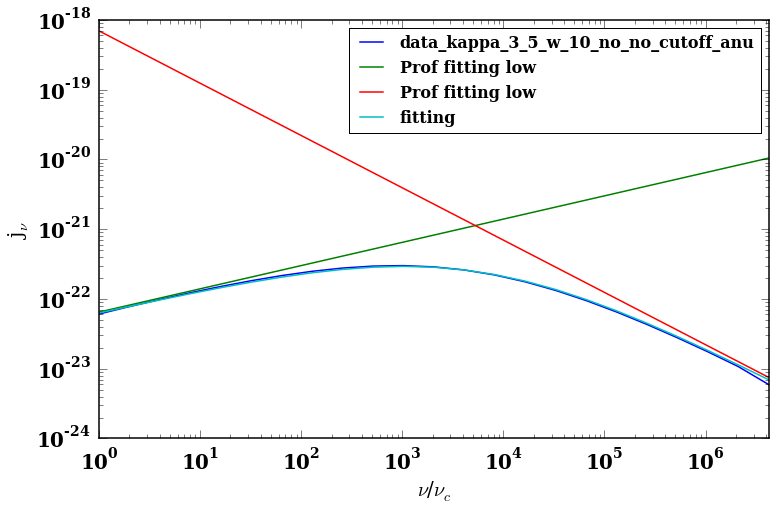

In [9]:

#............................................emissivity......................................................# 

#.......................with cutoff.........................................................................#

data_kappa_3_5_C_theta_10 = np.loadtxt('/home/zhaowei/Documents/synchrotron_calculator_new/emi_kappa_3_5_C_theta_10.txt')
data_kappa_3_5_C_theta_100 = np.loadtxt('/home/zhaowei/Documents/synchrotron_calculator_new/emi_kappa_3_5_C_theta_100.txt')

#......................without cutoff..........................................................................#
data_kappa_3_5_C_theta_10_no_cutoff = np.loadtxt('/home/zhaowei/Documents/synchrotron_calculator_new/emi_kappa_3_5_C_theta_10_no_cutoff.txt')
data_kappa_3_5_C_theta_10_no_cutoff_w_8 = np.loadtxt('/home/zhaowei/Documents/synchrotron_calculator_new/emi_kappa_3_5_C_theta_10_no_cutoff_w_8.txt')
data_kappa_3_5_C_theta_10_no_cutoff_w_6 = np.loadtxt('/home/zhaowei/Documents/synchrotron_calculator_new/emi_kappa_3_5_C_theta_10_no_cutoff_w_6.txt')
data_kappa_3_5_C_theta_10_no_cutoff_w_4 = np.loadtxt('/home/zhaowei/Documents/synchrotron_calculator_new/emi_kappa_3_5_C_theta_10_no_cutoff_w_4.txt')
data_kappa_3_5_C_theta_10_no_cutoff_w_3 = np.loadtxt('/home/zhaowei/Documents/synchrotron_calculator_new/emi_kappa_3_5_C_theta_10_no_cutoff_w_3.txt')

data_kappa_5_C_theta_10 = np.loadtxt('/home/zhaowei/Documents/synchrotron_calculator_new/emi_kappa_5_C_theta_10.txt')
data_kappa_5_C_theta_10_no_cutoff_w_10 = np.loadtxt('/home/zhaowei/Documents/synchrotron_calculator_new/emi_kappa_5_C_theta_10_no_cutoff_w_10.txt')
data_kappa_5_C_theta_10_no_cutoff_w_8 = np.loadtxt('/home/zhaowei/Documents/synchrotron_calculator_new/emi_kappa_5_C_theta_10_no_cutoff_w_8.txt')


#..........................................emissivity........................................................#






#................................................absorptivity...............................................#

#........................without cutoff.....................................................................#

data_kappa_3_C_theta_10_no_cutoff_w_10_anu = np.loadtxt('/home/zhaowei/Documents/kappa_summer/my_data_1/kappa_3_abs_nc_w_10.txt')

data_kappa_3_25_C_theta_10_no_cutoff_w_10_anu = np.loadtxt('/home/zhaowei/Documents/kappa_summer/my_data_1/kappa_3_25_abs_nc_w_10.txt')

data_kappa_3_5_C_theta_10_no_cutoff_w_30_anu = np.loadtxt('/home/zhaowei/Documents/kappa_summer/my_data_1/kappa_3_5_abs_nc_w_30.txt')
data_kappa_3_5_C_theta_10_no_cutoff_w_10_anu = np.loadtxt('/home/zhaowei/Documents/kappa_summer/my_data_1/kappa_3_5_abs_nc_w_10.txt')
data_kappa_3_5_C_theta_10_no_cutoff_w_8_anu = np.loadtxt('/home/zhaowei/Documents/kappa_summer/my_data_1/kappa_3_5_abs_nc_w_8.txt')
data_kappa_3_5_C_theta_10_no_cutoff_w_6_anu = np.loadtxt('/home/zhaowei/Documents/kappa_summer/my_data_1/kappa_3_5_abs_nc_w_6.txt')

data_kappa_3_75_C_theta_10_no_cutoff_w_10_anu = np.loadtxt('/home/zhaowei/Documents/kappa_summer/my_data_1/kappa_3_75_abs_nc_w_10.txt')

data_kappa_4_C_theta_10_no_cutoff_w_10_anu = np.loadtxt('/home/zhaowei/Documents/kappa_summer/my_data_1/kappa_4_abs_nc_w_10.txt')

data_kappa_4_25_C_theta_10_no_cutoff_w_10_anu = np.loadtxt('/home/zhaowei/Documents/kappa_summer/my_data_1/kappa_4_25_abs_nc_w_10.txt')

data_kappa_4_5_C_theta_10_no_cutoff_w_10_anu = np.loadtxt('/home/zhaowei/Documents/kappa_summer/my_data_1/kappa_4_5_abs_nc_w_10.txt')

data_kappa_4_75_C_theta_10_no_cutoff_w_10_anu = np.loadtxt('/home/zhaowei/Documents/kappa_summer/my_data_1/kappa_4_75_abs_nc_w_10.txt')

data_kappa_5_25_C_theta_10_no_cutoff_w_10_anu = np.loadtxt('/home/zhaowei/Documents/kappa_summer/my_data_1/kappa_5_25_abs_nc_w_10.txt')

data_kappa_5_C_thetta_10_no_cutoff_w_10_anu = np.loadtxt('/home/zhaowei/Documents/kappa_summer/my_data_1/kappa_5_abs_nc_w_10.txt')
data_kappa_5_C_thetta_10_no_cutoff_w_6_anu = np.loadtxt('/home/zhaowei/Documents/kappa_summer/my_data_1/kappa_5_abs_nc_w_6.txt')

data_kappa_5_5_C_theta_10_no_cutoff_w_10_anu = np.loadtxt('/home/zhaowei/Documents/kappa_summer/my_data_1/kappa_5_5_abs_nc_w_10.txt')

data_kappa_5_75_C_theta_10_no_cutoff_w_10_anu = np.loadtxt('/home/zhaowei/Documents/kappa_summer/my_data_1/kappa_5_75_abs_nc_w_10.txt')

data_kappa_6_C_theta_10_no_cutoff_w_10_anu = np.loadtxt('/home/zhaowei/Documents/kappa_summer/my_data_1/kappa_6_abs_nc_w_10.txt')

data_kappa_6_25_C_theta_10_no_cutoff_w_10_anu = np.loadtxt('/home/zhaowei/Documents/kappa_summer/my_data_1/kappa_6_25_abs_nc_w_10.txt')

data_kappa_6_5_C_theta_10_no_cutoff_w_10_anu = np.loadtxt('/home/zhaowei/Documents/kappa_summer/my_data_1/kappa_6_5_abs_nc_w_10.txt')

data_kappa_6_75_C_theta_10_no_cutoff_w_10_anu = np.loadtxt('/home/zhaowei/Documents/kappa_summer/my_data_1/kappa_6_75_abs_nc_w_10.txt')

data_kappa_7_C_theta_10_no_cutoff_w_10_anu = np.loadtxt('/home/zhaowei/Documents/kappa_summer/my_data_1/kappa_7_abs_nc_w_10.txt')

data_kappa_7_25_C_theta_10_no_cutoff_w_10_anu = np.loadtxt('/home/zhaowei/Documents/kappa_summer/my_data_1/kappa_7_25_abs_nc_w_10.txt')

data_kappa_7_5_C_theta_10_no_cutoff_w_10_anu = np.loadtxt('/home/zhaowei/Documents/kappa_summer/my_data_1/kappa_7_5_abs_nc_w_10.txt')

data_kappa_7_75_C_theta_10_no_cutoff_w_10_anu = np.loadtxt('/home/zhaowei/Documents/kappa_summer/my_data_1/kappa_7_75_abs_nc_w_10.txt')

data_kappa_8_25_C_theta_10_no_cutoff_w_10_anu = np.loadtxt('/home/zhaowei/Documents/kappa_summer/my_data_1/kappa_8_25_abs_nc_w_10.txt')

data_kappa_8_75_C_theta_10_no_cutoff_w_10_anu = np.loadtxt('/home/zhaowei/Documents/kappa_summer/my_data_1/kappa_8_75_abs_nc_w_10.txt')

data_kappa_9_25_C_theta_10_no_cutoff_w_10_anu = np.loadtxt('/home/zhaowei/Documents/kappa_summer/my_data_1/kappa_9_25_abs_nc_w_10.txt')

data_kappa_9_75_C_theta_10_no_cutoff_w_10_anu = np.loadtxt('/home/zhaowei/Documents/kappa_summer/my_data_1/kappa_9_75_abs_nc_w_10.txt')



deta_kappa_10_c_theta_10_no_cutoff_w_5_anu = np.loadtxt('/home/zhaowei/Documents/kappa_summer/kappa_10_abs_w_5.txt')


#................................................absorptivity.................................................#




data_kappa_150_C_theta_10 = np.loadtxt('/home/zhaowei/Documents/synchrotron_calculator_new/emi_kappa_150_C_theta_10.txt')
data_kappa_150_C_theta_100 = np.loadtxt('/home/zhaowei/Documents/synchrotron_calculator_new/emi_kappa_150_C_theta_100.txt')

data_thermal_C = np.loadtxt('/home/zhaowei/Documents/synchrotron_calculator_new/emi_thermal_C.txt')
data_power_2_5_theta_100 = np.loadtxt('/home/zhaowei/Documents/synchrotron_calculator_new/emi_power_2_5_C_theta_100.txt')

data_thermal_python = np.loadtxt('/home/zhaowei/Documents/synchrotron_calculator_new/thermal_data_varing_nu.txt')





#data_kappa_low_freg_finding_delta = np.loadtxt('/Users/zhaoweizhang/Documents/synchrotron_calculator_new/kappa_low_freg_finding_delta_vs_kappa.txt')


#data_kappa_150 = np.loadtxt('/Users/zhaoweizhang/Documents/synchrotron_calculator_new/emi_kappa_150_cut1000_C.txt')



#....................................................fitting function......................................#

def total_fitting(x):
    term1 = kappa_low(x)
    term2 = kappa_high(x)
    a = 3. * kappa**(- 3./2.)
#    f_mix = 1./(1./term1 + 1./term2)
#    f_mix2= np.sqrt(1./((1./term1)**2 + (1./term2)**2))
    f_mix3= (1./((1./term1)**(a) + (1./term2)**(a)))**(1./a)
#    f_mix4= (1./((1./(1.4 * term1))**(2./3.) + (1./( 1.2 * term2))**(2./3.)))**(3./2.)
#    f_mix5= (1./((1./term1)**(4./5.) + (1./term2)**(4./5.)))**(5./4.)
#    f_mix6= (1./((1./(1 * term1))**(2./3.) + (1./( term2))**(2./3.)))**(3./2.)
    return f_mix3





def total_fitting_anu(x):
    term1 =  (1./(np.pi**4.))*(m*c)*anu_low(x)
    term2 = anu_high(x)
    aa = -7.7516
    ab = 3.64007
    ac = 0.692185
    a = (aa + ab*kappa)**(-ac)
    f = (1./((1./term1)**(a) + (1./term2)**(a)))**(1./a)
    return f


#..................................................fitting function....................................#




x = np.arange(0, 1.677722e+07, 1)


#................................................plot data...............................................#

#pl.loglog(data_kappa_150[:,0], data_kappa_150[:, 1], label = 'kappa_150_data')
#pl.loglog(data_kappa_3_5[:,0], data_kappa_3_5[:, 1], label = 'kappa_3.5_data')
#pl.loglog(data_thermal_C[:,0], data_thermal_C[:, 1], label = 'thermal_data_C')
#pl.loglog(data_power_2_5_theta_100[:,0], data_power_2_5_theta_100[:, 1], label = 'power_data')
#pl.loglog(x, kappa_high_freq(x * nu_c), label = 'fitting_kappa_high_freg')
#pl.loglog(data_kappa_3_5_C_theta_100[:,0], data_kappa_3_5_C_theta_100[:, 1], label = 'kappa_3.5_theta_100')
#pl.loglog(data_kappa_150_C_theta_100[:,0], data_kappa_150_C_theta_100[:, 1], label = 'kappa_150_theta_100')
#pl.loglog(data_kappa_150_C_theta_10[:,0], data_kappa_150_C_theta_10[:, 1], label = 'kappa_150_theta_10')
#pl.loglog(data_thermal_python[:,0], data_thermal_python[:, 1], label = 'data_thermal_python')
#pl.semilogy(data_kappa_3_5_C_theta_100[:,0], abs(data_kappa_3_5_C_theta_100[:, 1] * np.pi/2 - kappa_low_freq(data_kappa_3_5_C_theta_100[:,0] * nu_c)), label = 'diff')
#pl.loglog(data_kappa_3_5_C_theta_10[:,0], data_kappa_3_5_C_theta_10[:, 1], label = 'kappa_3.5_theta_10')

#pl.loglog(data_kappa_3_5_C_theta_10_no_cutoff[:,0], data_kappa_3_5_C_theta_10_no_cutoff[:, 1], label = 'kappa_3.5_w_10_no_cutoff')
#pl.loglog(data_kappa_3_5_C_theta_10_no_cutoff_w_8[:,0], data_kappa_3_5_C_theta_10_no_cutoff_w_8[:, 1], label = 'kappa_3.5_theta_10_no_cutoff_w_8')
#pl.loglog(data_kappa_3_5_C_theta_10_no_cutoff_w_6[:,0], data_kappa_3_5_C_theta_10_no_cutoff_w_6[:, 1], label = 'kappa_3.5_theta_10_no_cutoff_w_6')
#pl.loglog(data_kappa_3_5_C_theta_10_no_cutoff_w_4[:,0], data_kappa_3_5_C_theta_10_no_cutoff_w_4[:, 1], label = 'kappa_3.5_theta_10_no_cutoff_w_4')
#pl.loglog(data_kappa_3_5_C_theta_10_no_cutoff_w_3[:,0], data_kappa_3_5_C_theta_10_no_cutoff_w_3[:, 1], label = 'kappa_3.5_theta_10_no_cutoff_w_3')
#pl.loglog(data_kappa_5_C_theta_10_no_cutoff_w_10[:,0], data_kappa_5_C_theta_10_no_cutoff_w_10[:, 1], label = 'kappa_5_theta_10_no_cutoff_w_10')
#pl.loglog(data_kappa_5_C_theta_10_no_cutoff_w_8[:,0], data_kappa_5_C_theta_10_no_cutoff_w_8[:, 1], label = 'kappa_5_theta_10_no_cutoff_w_8')

#pl.loglog(data_kappa_3_5_C_theta_10_no_cutoff_w_10_anu[:, 0], data_kappa_3_5_C_theta_10_no_cutoff_w_10_anu[:, 1], label = 'kappa_3_5_10_np_cutoff_anu')
#pl.loglog(data_kappa_5_C_thetta_10_no_cutoff_w_10_anu[:,0], data_kappa_5_C_thetta_10_no_cutoff_w_10_anu[:,1], label = 'kappa 5 w 10 anu data')
#l.loglog(deta_kappa_10_c_theta_10_no_cutoff_w_5_anu[:, 0], deta_kappa_10_c_theta_10_no_cutoff_w_5_anu[:, 1], label = 'kappa 10 w 5 data')
#pl.loglog(data_kappa_5_C_theta_10[:,0], data_kappa_5_C_theta_10[:, 1], label = 'kappa_5_theta_10')

#pl.loglog(data_kappa_3_5_C_theta_10_no_cutoff_w_6_anu[:, 0], data_kappa_3_5_C_theta_10_no_cutoff_w_6_anu[:,1], label = 'kappa_3_5_6_np_cutoff_anu')
#pl.loglog(data_kappa_5_C_thetta_10_no_cutoff_w_6_anu[:, 0], data_kappa_5_C_thetta_10_no_cutoff_w_6_anu[:,1], label = 'kappa_5_10_np_cutoff_anu')
pl.loglog(data_kappa_3_5_C_theta_10_no_cutoff[:,0], data_kappa_3_5_C_theta_10_no_cutoff[:,1], label = 'data_kappa_3_5_w_10_no_no_cutoff_anu')

#..................................plot fitting formula.................................................#

#pl.loglog(data_kappa_3_5_C_theta_10_no_cutoff[:,0], emi_fitting_low_prof(data_kappa_3_5_C_theta_10_no_cutoff[:,0] * nu_c), label = 'Prof fitting low')
#pl.loglog(data_kappa_3_5_C_theta_10_no_cutoff[:,0], emi_fitting_mid_prof(data_kappa_3_5_C_theta_10_no_cutoff[:,0] * nu_c), label = 'Prof fitting mid')
pl.loglog(data_kappa_3_5_C_theta_10_no_cutoff[:,0], kappa_low(data_kappa_3_5_C_theta_10_no_cutoff[:,0]), label = 'Prof fitting low')
pl.loglog(data_kappa_3_5_C_theta_10_no_cutoff[:,0], kappa_high(data_kappa_3_5_C_theta_10_no_cutoff[:,0]), label = 'Prof fitting low')
#pl.loglog(data_kappa_3_5_C_theta_10_no_cutoff[:,0], emi_fitting_mis_ours_2(data_kappa_3_5_C_theta_10_no_cutoff[:,0] * nu_c), label = 'check Prof')
#pl.loglog(data_kappa_3_5_C_theta_10_no_cutoff[:,0], fit(data_kappa_3_5_C_theta_10_no_cutoff[:,0]), label = 'check')
#pl.loglog(x, kappa_low_freq(x * nu_c), label = 'fitting_kappa_low_freg')
#pl.loglog(x, kappa_low_freq(x * nu_c), label = 'fitting_kappa_low_freg')
#pl.loglog(x, kappa_middle_freg(x * nu_c)/2, label = 'fitting_kappa_mid_freg')
#pl.loglog(x, kappa_middle_freg(x * nu_c), label = 'fitting_kappa_mid_freg')

#pl.loglog(data_kappa_3_5_C_theta_10_no_cutoff_w_10_anu[:, 0], kappa_low_anu(data_kappa_3_5_C_theta_10_no_cutoff_w_10_anu[:, 0]), label = 'fitting low frequency')
pl.loglog(data_kappa_3_5_C_theta_10_no_cutoff[:,0], total_fitting(data_kappa_3_5_C_theta_10_no_cutoff[:,0]), label = 'fitting')

#pl.loglog(data_kappa_3_5_C_theta_10_no_cutoff_w_10_anu[:, 0], (1./w)*(1./(16.))*(m*c)*anu_low(data_kappa_3_5_C_theta_10_no_cutoff_w_10_anu[:, 0]))
#pl.loglog(data_kappa_3_5_C_theta_10_no_cutoff_w_10_anu[:, 0], anu_high(data_kappa_3_5_C_theta_10_no_cutoff_w_10_anu[:, 0]))
#pl.loglog(data_kappa_3_5_C_theta_10_no_cutoff_w_10_anu[:, 0], total_fitting_anu(data_kappa_3_5_C_theta_10_no_cutoff_w_10_anu[:,0]), label = 'fitting total')

#pl.loglog(data_kappa_3_5_C_theta_10_no_cutoff_w_10_anu[:, 0], (1./(np.pi**4.))*(m*c)*anu_low(data_kappa_3_5_C_theta_10_no_cutoff_w_10_anu[:, 0]), label = 'low frequency fitting')
#pl.loglog(data_kappa_3_5_C_theta_10_no_cutoff_w_10_anu[:, 0], anu_high(data_kappa_3_5_C_theta_10_no_cutoff_w_10_anu[:, 0]), label = 'high frquency fitting')
#pl.loglog(data_kappa_3_5_C_theta_10_no_cutoff_w_10_anu[:, 0], total_fitting_anu(data_kappa_3_75_C_theta_10_no_cutoff_w_10_anu[:,0]), label = 'fitting')



#pl.loglog(data_kappa_3_5_C_theta_10_no_cutoff_w_6_anu[:, 0], total_fitting_anu(data_kappa_3_5_C_theta_10_no_cutoff_w_6_anu[:,0]), label = 'fitting total')

#pl.loglog(data_kappa_5_C_thetta_10_no_cutoff_w_6_anu[:, 0], anu_high(data_kappa_5_C_thetta_10_no_cutoff_w_6_anu[:, 0]))


pl.xlim([0, 4.194304e+06])
#pl.ylim([1e-14, 1e-11])
pl.xlabel("$\\nu$/$\\nu_c$")
pl.ylabel("j$_\\nu$")
pl.legend(loc = 'upper right', prop= {'size':16})
pl.show()




#................................................error......................................................#

def error_here_here(x):
    ans = total_fitting(x)/data_kappa_3_5_C_theta_10[:,1] - 1
    return ans

#pl.loglog(data_kappa_3_5_C_theta_10_no_cutoff[:,0], emi_fitting_low_prof(data_kappa_3_5_C_theta_10_no_cutoff[:,0] * nu_c), label = 'Prof fitting low')

#pl.loglog(data_kappa_3_5_C_theta_10_no_cutoff[:,0], emi_fitting_mid_prof(data_kappa_3_5_C_theta_10_no_cutoff[:,0] * nu_c), label = 'Prof fitting mid')


#pl.semilogx(data_kappa_3_5_C_theta_10[:,0], error_here_here(data_kappa_3_5_C_theta_10[:,0]*nu_c), label = 'fitting/data - 1')

#pl.xlim([0, 1e6])
#pl.ylim([-0.2,0.2])
#pl.legend()
#pl.show()

#print 8. * np.pi**3






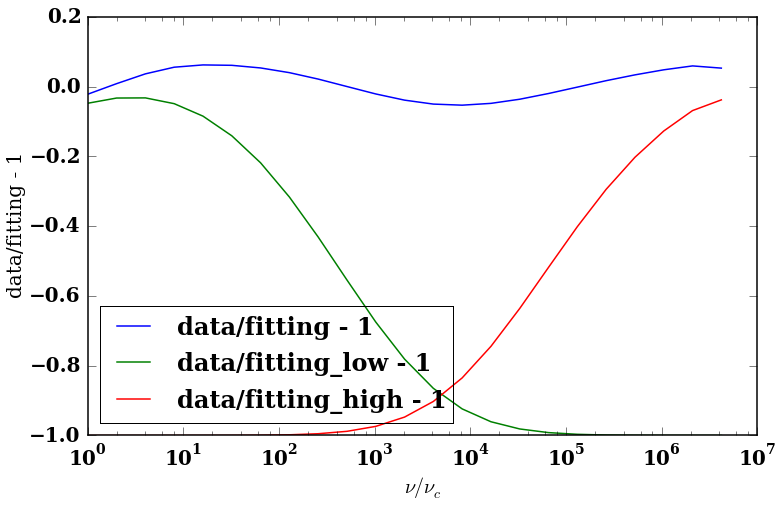

In [5]:
def error_herehere():
    x = data_kappa_3_5_C_theta_10_no_cutoff_w_10_anu[:,0]
    y = data_kappa_3_5_C_theta_10_no_cutoff_w_10_anu[:,1]
    f = y/total_fitting_anu(data_kappa_3_75_C_theta_10_no_cutoff_w_10_anu[:,0]) - 1.
    return f
    
pl.semilogx(data_kappa_3_75_C_theta_10_no_cutoff_w_10_anu[:,0], error_herehere(), label = 'data/fitting - 1')



def error_hereherher():
    x = data_kappa_3_5_C_theta_10_no_cutoff_w_10_anu[:,0]
    y = data_kappa_3_5_C_theta_10_no_cutoff_w_10_anu[:,1]
    f = y/((1./(np.pi**4.))*(m*c)*anu_low(data_kappa_3_5_C_theta_10_no_cutoff_w_10_anu[:, 0])) - 1.
    return f

def error_2():
    x = data_kappa_3_5_C_theta_10_no_cutoff_w_10_anu[:,0]
    y = data_kappa_3_5_C_theta_10_no_cutoff_w_10_anu[:,1]
    f = y/anu_high(data_kappa_3_5_C_theta_10_no_cutoff_w_10_anu[:, 0]) - 1.
    return f
    
pl.semilogx(data_kappa_3_75_C_theta_10_no_cutoff_w_10_anu[:,0], error_hereherher(), label = 'data/fitting_low - 1')
pl.semilogx(data_kappa_3_75_C_theta_10_no_cutoff_w_10_anu[:,0], error_2(), label = 'data/fitting_high - 1')
 
    
pl.xlabel("$\\nu/\\nu_c$")
pl.ylabel("data/fitting - 1")
pl.legend(loc = 'lower left')
pl.show()

    

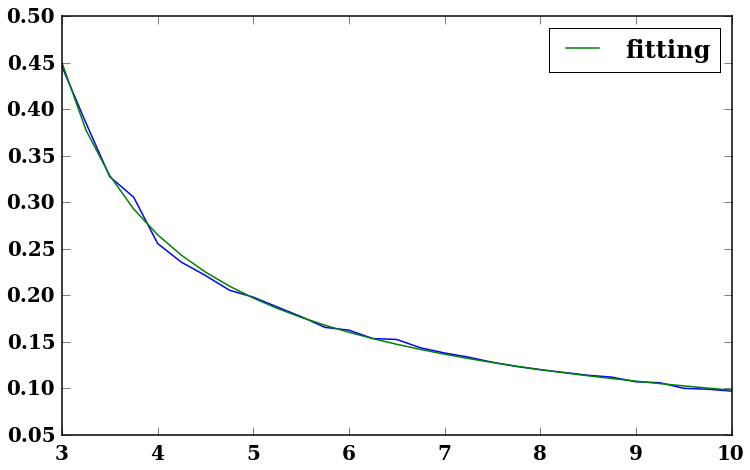

In [6]:
data_kappa_vs_x = np.loadtxt('/home/zhaowei/Documents/kappa_summer/my_data_1/kappa_vs_x.txt')

def fitting_kappa_vs_x(x):
    a = -7.7516
    b = 3.64007
    c = 0.692185
    f = (a + b*x)**(-c)
    return f

#print curve_fit(fitting_kappa_vs_x, data_kappa_vs_x[:,0], data_kappa_vs_x[:,1])


pl.plot(data_kappa_vs_x[:,0], data_kappa_vs_x[:,1])
pl.plot(data_kappa_vs_x[:,0], fitting_kappa_vs_x(data_kappa_vs_x[:,0]), label = 'fitting')

#data_numerical = data_kappa_vs_x[:,1]
#data_fit       = fitting_kappa_vs_x(data_kappa_vs_x[:,0], 1.73738273, -1.31401136)
#err = data_numerical/data_fit - 1.

#pl.plot(data_kappa_vs_x[:,0], abs(err) )




pl.legend()
pl.show()

In [5]:
1./1.4447

0.6921852287672181

(0, 30)

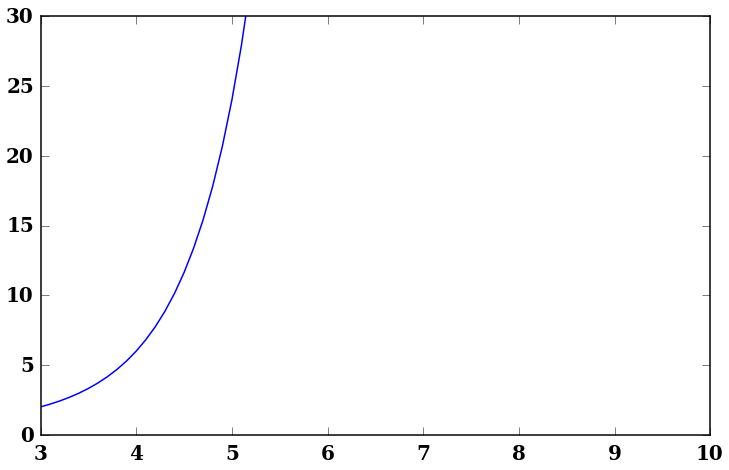

In [23]:
x = np.arange(3, 10, 0.1)

y = special.gamma(x)

pl.plot(x, y)

pl.ylim([0,30])

